In this notebook we will experiment with the AL bias mitigation technique from Richards. 
We will do this on a synthetically biased sample (sample size=700) that we obtained from the CERN dataset, with the rf classifier trained on 10 percent of the data and using a=1/28 and k=0 for the bin distribution

In [21]:
# Some notes:
# - If you use df.loc[i], you get the instance that had index i in the original dataframe.
# - If you use df.l=iloc[i], you get the ith instance n the current dataframe.

In [22]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time
import warnings

warnings.filterwarnings(action='ignore')

# Import data

In [23]:
def read_file(url):

    url = url + "?raw=true"
    df = pd.read_csv(url, encoding='cp1252', sep=',', low_memory=False)
    return df

In [24]:
df = read_file("https://github.com/hannahgathu/Thesis-Data-Visualisations/blob/main/Data/benchmark_data/Test_datasets/bias_and_noise/CERN_testing_set_300_1000.csv")
#df = read_file("https://github.com/hannahgathu/Thesis-Data-Visualisations/blob/main/Data/benchmark_data/Test_datasets/bias_and_noise/CERN_testing_set_50_300.csv")
df_og = read_file("https://github.com/hannahgathu/Thesis-Data-Visualisations/blob/main/Data/benchmark_data/dielectron_classification.csv")

# Prep data

In [25]:
# create sample and pool, the sample has size 700
df['s1']=df['pz1']
df['s2']=df['pz2']

sample=df[df['in_biased_sample']==1]
pool=df[df['in_biased_sample']==0]


### Add extra bias

In [26]:
#add noise to s
for i in range(sample.shape[0]):
    sample['s1'].at[i]=sample['s1'][i]+np.random.normal(0,30)
    
#add noise to s
for i in range(sample.shape[0]):
    sample['s2'].at[i]=sample['s2'][i]+np.random.normal(0,30)

In [27]:
sample=sample[(sample['s1'] < 30) & (sample['s1']>-30) & (sample['s2'] < 30) & (sample['s2']>-30)]

In [28]:
sample.shape[0]

59

In [29]:
sample_og=sample
pool_og=pool

In [42]:
sample=sample_og
pool=pool_og

In [43]:
X=df.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y=df.M>21.3
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

In [32]:
X_og=df_og.drop(columns=['M>21.3','M','Run','Event'])
y_og=df_og.M>21.3

# Train rf classifier

In [44]:
#train classifier on sample
rf = RandomForestClassifier()
t0 = time()
rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)
print ('training time: ', round(time()-t0, 3), 's')

training time:  0.092 s


In [45]:
#accuracy on X (whole set)
t1=time()
pred_rf = rf.predict(X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1))
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y, pred_rf))

predicting time:  0.016 s
Accuracy: 0.6946153846153846


In [46]:
pred_rf = rf.predict(X_og)
print("Accuracy:",metrics.accuracy_score(y_og, pred_rf))

Accuracy: 0.65624


## Random Forest

In [36]:
##get proximity matrix
def get_proximity_matrix(X, rf):
    
    #find proportion of indices that match between i and j
    #compute the symmetric matrix
    
    n=X.shape[0]
    tree_idxs = rf.apply(X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1))
    proximity_matrix = np.empty(shape=(n, n))
    
    for i in range(n):
        for j in range(n):
            proximity_matrix[i,j] = np.sum(np.equal(tree_idxs[i,:], tree_idxs[j,:]))
    return proximity_matrix

In [37]:
##get maximum probabilities
def get_max_class_probabilities(X,rf):
    class_probabilities= rf.predict_proba(X.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1))
    max_class_probabilities=[0]*(len(class_probabilities))
    for i in range (len(class_probabilities)):
        max_class_probabilities[i]=max(class_probabilities[i,0],class_probabilities[i,1])
    return max_class_probabilities

In [38]:
#X=training set, pool=pool of instances to pick from
rf = RandomForestClassifier()
rf.fit(X_sample,y_sample)
#proximity_matrix=get_proximity_matrix(X+pool,rf)

RandomForestClassifier()

## AL query functions

In [39]:
def get_sum_of_proximities(i1, ys, proximity_matrix):
    proximities=[0]*len(ys)
    for i in range(len(ys)):
        proximities[i]=proximity_matrix[i,i1]
    sum_of_proximities=sum(proximities)
    return sum_of_proximities
        

In [40]:
def s_2(i, proximity_matrix):
    S_2 = get_sum_of_proximities(i, X_pool.index, proximity_matrix)*(1-max_class_probabilities[i])/(get_sum_of_proximities(i, X_sample.index, proximity_matrix)+1)
    return S_2

def uncertainty(i):
    return (1- max_class_probabilities[i])
    
def query_instance (X_sample, X_pool, rf, proximity_matrix, query_mode="s2"):
    max_class_probabilities= get_max_class_probabilities(X, rf)
    #proximity_matrix = get_proximity_matrix(X, rf)
    
    if (query_mode=="s2"):
        s_2_scores=[0]*X_pool.shape[0] 
    else: uncertainty_scores=[0]*X_pool.shape[0]
    
    for i in range(X_pool.shape[0]):
        if (query_mode=="s2"):
            s_2_scores[i]=s_2(int(X_pool.iloc[i].iloc[0]), proximity_matrix)
        else: uncertainty_scores[i]= uncertainty(int(X_pool.iloc[i].iloc[0]))
    if (query_mode=="s2"):
        queried_instance_index = int(X_pool.iloc[np.argmax(s_2_scores)].iloc[0])
    else: queried_instance_index = int(X_pool.iloc[np.argmax(uncertainty_scores)].iloc[0])
    return queried_instance_index

    #what I want to do:
    #get all values of s2 for the instances in the pool in a list
    #get the argmax, which gives the index i with the highest s2 score
    #get the instancce from the pool by using 
    #int(X_sample.iloc[0].iloc[0])

## Compare with and without density criterium for different metrics

time:  9.343 s
time:  26.268 s
time:  43.169 s
time:  59.908 s
time:  77.111 s
time:  94.51 s
time:  111.888 s
time:  129.085 s
time:  146.284 s
time:  163.734 s
time:  181.133 s
time:  198.588 s
time:  216.182 s
time:  233.901 s
time:  251.674 s
time:  269.49 s
time:  287.394 s
time:  307.261 s
time:  330.311 s
time:  349.958 s
time:  369.293 s
time:  388.186 s
time:  407.935 s
time:  428.821 s
time:  450.05 s
time:  470.737 s
time:  490.024 s
time:  509.482 s
time:  528.864 s
time:  549.124 s
time:  569.193 s
time:  588.904 s
time:  608.762 s
time:  630.166 s
time:  650.334 s
time:  670.312 s
time:  691.459 s
time:  712.783 s
time:  733.557 s
time:  755.683 s
time:  775.744 s
time:  797.306 s
time:  817.531 s
time:  837.456 s
time:  856.995 s
time:  876.44 s
time:  896.262 s
time:  915.56 s
time:  935.104 s
time:  955.812 s
time:  976.64 s
time:  997.495 s
time:  1017.417 s
time:  1037.039 s
time:  1056.85 s
time:  1078.314 s
time:  1098.08 s
time:  1117.323 s
time:  1136.656 s
time:

Text(0.5, 1.0, 'Precision for 995 iterations with sample size 59 and pool size 1000')

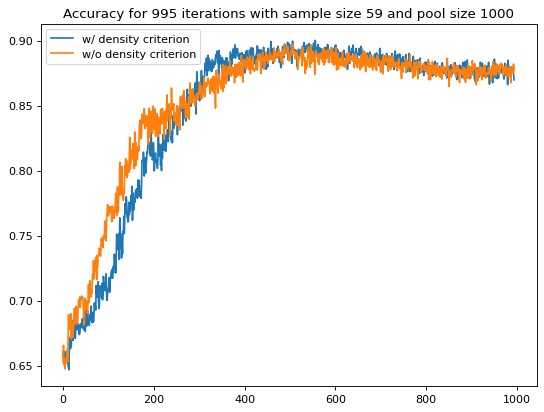

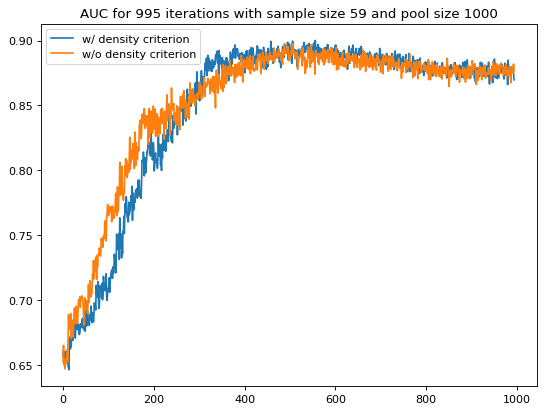

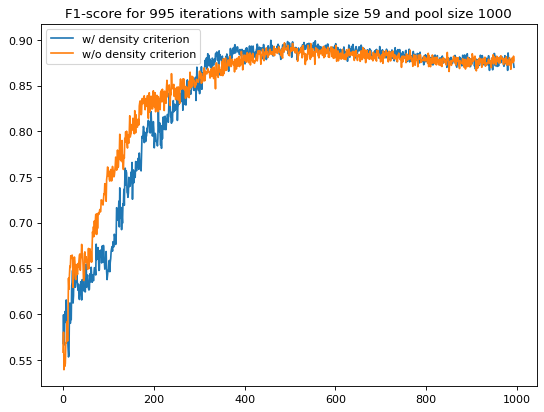

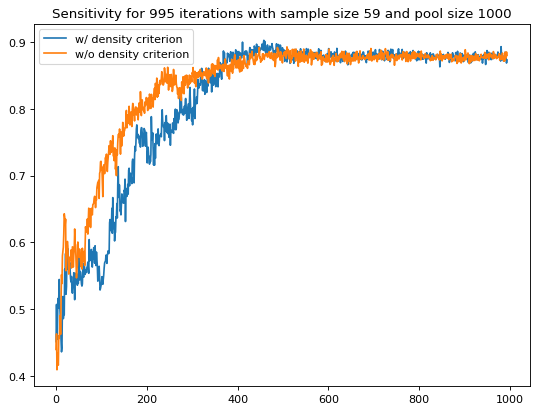

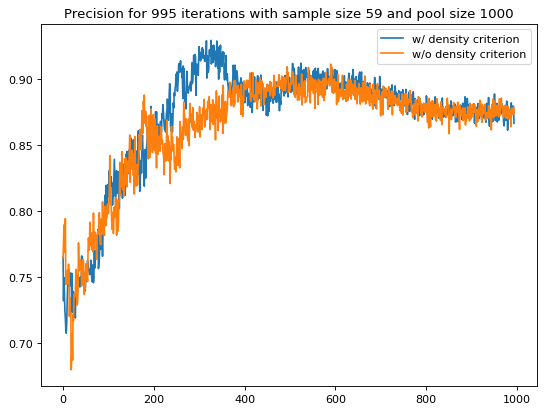

In [47]:
n_of_iterations=995

t0 = time()

sample_size  = sample.shape[0]
pool_size = pool.shape[0]

#run AL algorithm
queried_instances=[]
rf = RandomForestClassifier()

sensitivities=[0]*n_of_iterations
f1scores=[0]*n_of_iterations
precisions=[0]*n_of_iterations
accuracies=[0]*n_of_iterations
auc_scores=[0]*n_of_iterations

t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store metrics
    pred_rf = rf.predict(X_og)
    accuracies[i] = metrics.accuracy_score(y_og, pred_rf)
    #classification_report = metrics.classification_report(y_og, pred_rf, output_dict=True)
    sensitivities[i]= metrics.recall_score(y_og, pred_rf)
    f1scores[i]= metrics.f1_score(y_og, pred_rf)
    precisions[i]= metrics.precision_score(y_og, pred_rf)
    fpr, tpr, thresholds = metrics.roc_curve(y_og, pred_rf)
    auc_scores[i]= metrics.auc(fpr, tpr)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print ('time: ', round(time()-t0, 3), 's')
    n = query_instance(X_sample, X_pool, rf, proximity_matrix)
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final metrics
pred_rf = rf.predict(X_og)
accuracies[n_of_iterations-1] = metrics.accuracy_score(y_og, pred_rf)
sensitivities[n_of_iterations-1] = metrics.recall_score(y_og, pred_rf)
f1scores[n_of_iterations-1] = metrics.f1_score(y_og, pred_rf)
precisions[n_of_iterations-1] = metrics.precision_score(y_og, pred_rf)
fpr, tpr, thresholds = metrics.roc_curve(y_og, pred_rf)
auc_scores[n_of_iterations-1]= metrics.auc(fpr, tpr)

#store stuff
accuracies_with_density = accuracies
queried_instances_with_density=queried_instances
confusion_matrix_with_density=metrics.confusion_matrix(y_og, pred_rf)
sensitivities_with_density=sensitivities
f1scores_with_density=f1scores
precisions_with_density=precisions
auc_scores_with_density=auc_scores
final_sample_with_density=sample

#reset sample and pool
sample=sample_og
pool=pool_og
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample','s1', 's2'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

#run AL algorithm without density criterium
queried_instances=[]
rf = RandomForestClassifier()
sensitivities=[0]*n_of_iterations
f1scores=[0]*n_of_iterations
precisions=[0]*n_of_iterations
accuracies=[0]*n_of_iterations
auc_scores=[0]*n_of_iterations

t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)

    #store metrics
    pred_rf = rf.predict(X_og)
    accuracies[i] = metrics.accuracy_score(y_og, pred_rf)
    #classification_report = metrics.classification_report(y_og, pred_rf, output_dict=True)
    sensitivities[i]= metrics.recall_score(y_og, pred_rf)
    f1scores[i]= metrics.f1_score(y_og, pred_rf)
    precisions[i]= metrics.precision_score(y_og, pred_rf)
    fpr, tpr, thresholds = metrics.roc_curve(y_og, pred_rf)
    auc_scores[i]= metrics.auc(fpr, tpr)

    #query instance and add to sample
    max_class_probabilities= get_max_class_probabilities(X, rf)
        #query instance and add to sample
    if (i%10 == 0):
        proximity_matrix = get_proximity_matrix(X, rf)
        print ('time: ', round(time()-t0, 3), 's')
    
    n = query_instance(X_sample, X_pool, rf, proximity_matrix, "uncertainty")
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)

#store final metrics
pred_rf = rf.predict(X_og)
accuracies[n_of_iterations-1] = metrics.accuracy_score(y_og, pred_rf)
sensitivities[n_of_iterations-1] = metrics.recall_score(y_og, pred_rf)
f1scores[n_of_iterations-1] = metrics.f1_score(y_og, pred_rf)
precisions[n_of_iterations-1] = metrics.precision_score(y_og, pred_rf)
fpr, tpr, thresholds = metrics.roc_curve(y_og, pred_rf)
auc_scores[n_of_iterations-1]= metrics.auc(fpr, tpr)


#store stuff
accuracies_without_density = accuracies
queried_instances_without_density=queried_instances
confusion_matrix_without_density=metrics.confusion_matrix(y_og, pred_rf)
sensitivities_without_density=sensitivities
f1scores_without_density=f1scores
auc_scores_without_density=auc_scores
precisions_without_density=precisions
final_sample_without_density=sample

#Plot metrics
#accuracy
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_density, label="w/ density criterion")
plt.plot(accuracies_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

#auc_score
figure(figsize=(8, 6), dpi=80)
plt.plot(auc_scores_with_density, label="w/ density criterion")
plt.plot(auc_scores_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("AUC for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

#fscore
figure(figsize=(8, 6), dpi=80)
plt.plot(f1scores_with_density, label="w/ density criterion")
plt.plot(f1scores_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("F1-score for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

#sensitivity
figure(figsize=(8, 6), dpi=80)
plt.plot(sensitivities_with_density, label="w/ density criterion")
plt.plot(sensitivities_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Sensitivity for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

#precision
figure(figsize=(8, 6), dpi=80)
plt.plot(precisions_with_density, label="w/ density criterion")
plt.plot(precisions_without_density, label="w/o density criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Precision for {} iterations with sample size {} and pool size {}".format(n_of_iterations, sample_size, pool_size))

In [38]:
print(metrics.f1_score(y_og, pred_rf))

0.5961630816672142


In [34]:
print(metrics.classification_report(y_og, pred_rf, output_dict=True).get('f1-score'))

None


In [35]:
 metrics.classification_report(y_og, pred_rf, output_dict=True).keys()

dict_keys(['False', 'True', 'accuracy', 'macro avg', 'weighted avg'])

In [64]:
precisions_without_density[2]

0.8398997134670487